In [21]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

In [73]:
# Define the helper functions

def defaultValue(value, default_value):
    if value is not None:
        return value
    return default_value() if isfunction(default_value) else default_value


In [79]:
# Network helper components.

# Residual net layer.
class Residual(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.activation_fn = activation_fn

    def forward(self, x, *args, **kwargs):
        return self.activation_fn(x, *args, **kwargs) + x

# Conv upsampling layer, it upsamples the image by scale of 2 (twice).
def Upsample(dim_in: int, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim_in, defaultValue(dim_out, dim_in), kernel_size=3, padding=1),
    )

# Conv downsampling layer, it downsamples the image by half.
def Downsample(dim_in: int, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        # Split each image into 4 smaller images, and stack all four sub-images into
        # the channels.
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        # Use the conv to sequeeze the dim as output one.
        nn.Conv2d(dim * 4, defaultValue(dim_out, dim_in), 1),
    )

# Positional embedding layer.
# We use the positional embedding to encode the timestamp t.
# Here the timestamp means the t in the diffusion process.
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    # The time has dim: [B, 1], here 1 mean the correpsonding timestamp for that img.
    # Recall the sin position embeddings are:
    # PE(pos, 2i) = sin(pos/10000^{2i/d}) = sin(pos * exp (-1 * i * log(10000) / (d/2))).
    # PE(pos, 2i+1) = cos(pos/10000^{2i/d}).
    def forward(self, time: torch.Tensor):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Assemble the CNN layers
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x: torch.Tensor):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()
        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


# This is a general CNN block which has group norm and SiLU.
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x: torch.Tensor, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim: int, dim_out: int, *, time_emb_dim=None, groups=8):
        super().__init__()
        # Applys a MLP to encode the time embeddings (i.e. SinusoidalPosition).
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if time_emb_dim is not None
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.Tensor, time_emb=None):
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            # Split the time embeddings into two tensors.
            # One tensor is added as shift and another one is multiple as scale.
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

# This layer uses CNN to encode/decode the input vectors.
# Idea is to treat channels as the embedding/token vector, each pixel as one token.
# conduct the self-attention among all pixels.
class Attention(nn.Module):
    # dim is the input tensor's channel dimensions.
    # dim_head is the Q/K/V's dimension for each head.
    def __init__(self, dim: int, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        # Note for conv, input is [B, C, H, W], and same for the output.
        self.to_qkv = nn.Conv2d(in_channels=dim, out_channels=hidden_dim * 3, kernel_size=1, bias=False)
        self.to_out = nn.Conv2d(in_channels=hidden_dim, out_channels=dim, kernel_size=1)

    # We assume the input tensor has shape of [batch_size, channels, height, weight]
    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        # Use the CNN layer to encode the QKV into a big tensor, then
        # split it into 3 views (split by channel).
        qkv = self.to_qkv(x).chunk(3, dim=1)
        # Regroup the QKV tensors, here h means head.
        # After mapping, QKV has shape [batch, heads, channels, x*y]
        # thus, we only need to perform tranformer on the last dim.
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        # Q * K in the attention. Here means we perform attention along the channel
        # dimention, for each pixel (i means the pixel in Q, j means pixel in K).
        sim = einsum("b h c i, b h c j -> b h i j", q, k)
        # amax is argmax. Here we subtract the max dim to make softmax more numerical stable
        # here we don't want the amax's gradient pass to the params, thus, uses detach.
        # The detach just create a stopped gradient placerholder for that original tensor.
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h c j -> b h i c", attn, v)
        out = rearrange(out, "b h (x y) c -> b (h c) x y", x=h, y=w)
        return self.to_out(out)

# See https://arxiv.org/abs/1812.01243.
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

# Group norm layer. It's applied before transformer.
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [80]:
# Define the U-net. The input to the Unet is a noise image batches,
# we expect it returns the noise. The input tensor shape is [B, channels, h, w].
class Unet(nn.Module):
    # dim: a general unit of the internal layer's dimenstion;
    #      e.g. the channel num of downsample/upsample cnn.
    # init_dim: there is a cnn as the first layer, it converts
    #      input image channels to this init_dim.
    # out_dim: the channels of final returned tensor. The U-net
    #      is mirror for upsampling and downsampling. Thus, the image
    #      size is the same as the noise size (w, h).
    # channels: the number of the image channels;
    # resnet_block_groups: the hyperparams for the group normalization
    #      in the resnet sub-module.
    def __init__(
        self,
        dim: int,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = defaultValue(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        # The dims is [init_dim, dim, 2dim, 4dim, 8dim].
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        # The in_out is [(init_dim, dim), (dim, 2dim), (2dim, 4dim), (4dim, 8dim)]
        in_out = list(zip(dims[:-1], dims[1:]))

        print('in-out')
        print(in_out)

        resnet_block = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        # Build stacks to downsample the images.
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
                        resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
                        # Apply residual connection for norm layer + linear attention.
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        # Apply connv to downsample the image.
                        # If not the last layer, we split image into 4 sub images and stack
                        # them into channels to perform dim_out. Thus, image size shrink by half.
                        Downsample(dim_in, dim_out)
                        if not is_last
                        # For the last layer, we simply conduct a conv2d, without change
                        # the image size.
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        # The mid dim is 8 dim, the time dim is 4 dim.
        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        resnet_block(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        # Similar as downsample, the non-last layer upsample double the image
                        # size by nearest upsampling.
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = defaultValue(out_dim, channels)

        self.final_res_block = resnet_block(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    # x is the input images with size as [B, channels, h, w];
    # time is the timestamp tensor (in diffusion steps),  with size as [B, 1]
    def forward(self, x: torch.Tensor, time: torch.Tensor, x_self_cond=None):
        if self.self_condition:
            x_self_cond = defaultValue(x_self_cond, lambda: torch.zeros_like(x))
            # Stack the zeros or identiy images into the channels.
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        # The clone will allow the gradients flow back.
        # r will be directly stack to the last output layer as a residual connection.
        residual_input_from_x = x.clone()

        t = self.time_mlp(time)

        # we use h hold the output of downsample cnns.
        # Those output will be passed to upsampler as a residual connection.
        h = []
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            # Here we attach the output of downsample's cnn layer,
            # it's similar as a residual connection.
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, residual_input_from_x), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [44]:
# Define the forward gaussain process (q).

# Define the schedule of betas, which controls the strength of noise.
# It return the 1D tensor whose size is total_timesteps.
def linear_beta_schedule(total_timesteps: int):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, total_timesteps)

class Alphas():
    def __init__(self, total_timestamps: int):
        super().__init__()
        self.total_timestamps = total_timestamps
        self.betas = linear_beta_schedule(total_timestamps)
        alphas = 1. - self.betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        self.sqrt_alpha_bars = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_bars = torch.sqrt(1.0 - alphas_cumprod)

    # We expect the t is a 2d tensor with shape [B, 1] or [B]
    # We return [B, 1, ..., 1] tensor, the number of dimensions matches with image_shape.
    # E.g. image_shape = [10, 3, 64, 64], then we return [10, 1, 1, 1].
    def get_sqrt_alpha_bar_t(self, t: torch.Tensor, image_shape):
        batch_size = t.shape[0]
        sqrt_alpha_bar_t = torch.gather(input=self.sqrt_alpha_bars, dim=-1, index=t.long())
        return sqrt_alpha_bar_t.reshape(batch_size, *((1,) * (len(image_shape) - 1)))

    def get_sqrt_one_minus_alphas_bar_t(self, t: torch.Tensor, image_shape):
        batch_size = t.shape[0]
        sqrt_one_minus_alphas_bar_t = torch.gather(
            input=self.sqrt_one_minus_alphas_bars, dim=-1, index=t.long())
        return sqrt_one_minus_alphas_bar_t.reshape(
            batch_size, *((1,) * (len(image_shape) - 1)))


# forward diffusion: q(x_t | x_0)
# q(x_t | x_0) = N(x_t; mean= sqrt(alpha_bar_t) * x_0, var =(1 - alpha_bar_t)I)
def q_sample(x_start: torch.Tensor, t, alphas: Alphas, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alpha_bar_t = alphas.get_sqrt_alpha_bar_t( t, x_start.shape)
    sqrt_one_minus_alphas_bar_t = alphas.get_sqrt_one_minus_alphas_bar_t(
        t, x_start.shape)

    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alphas_bar_t * noise

# Define the diffusion loss.
def p_losses(denoise_model, x_start: torch.Tensor, 
             t: torch.Tensor, alphas: Alphas, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, alphas=alphas, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [37]:
# Image pre-process
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from PIL import Image
import requests
from typing import Dict, Tuple, List

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1),
])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

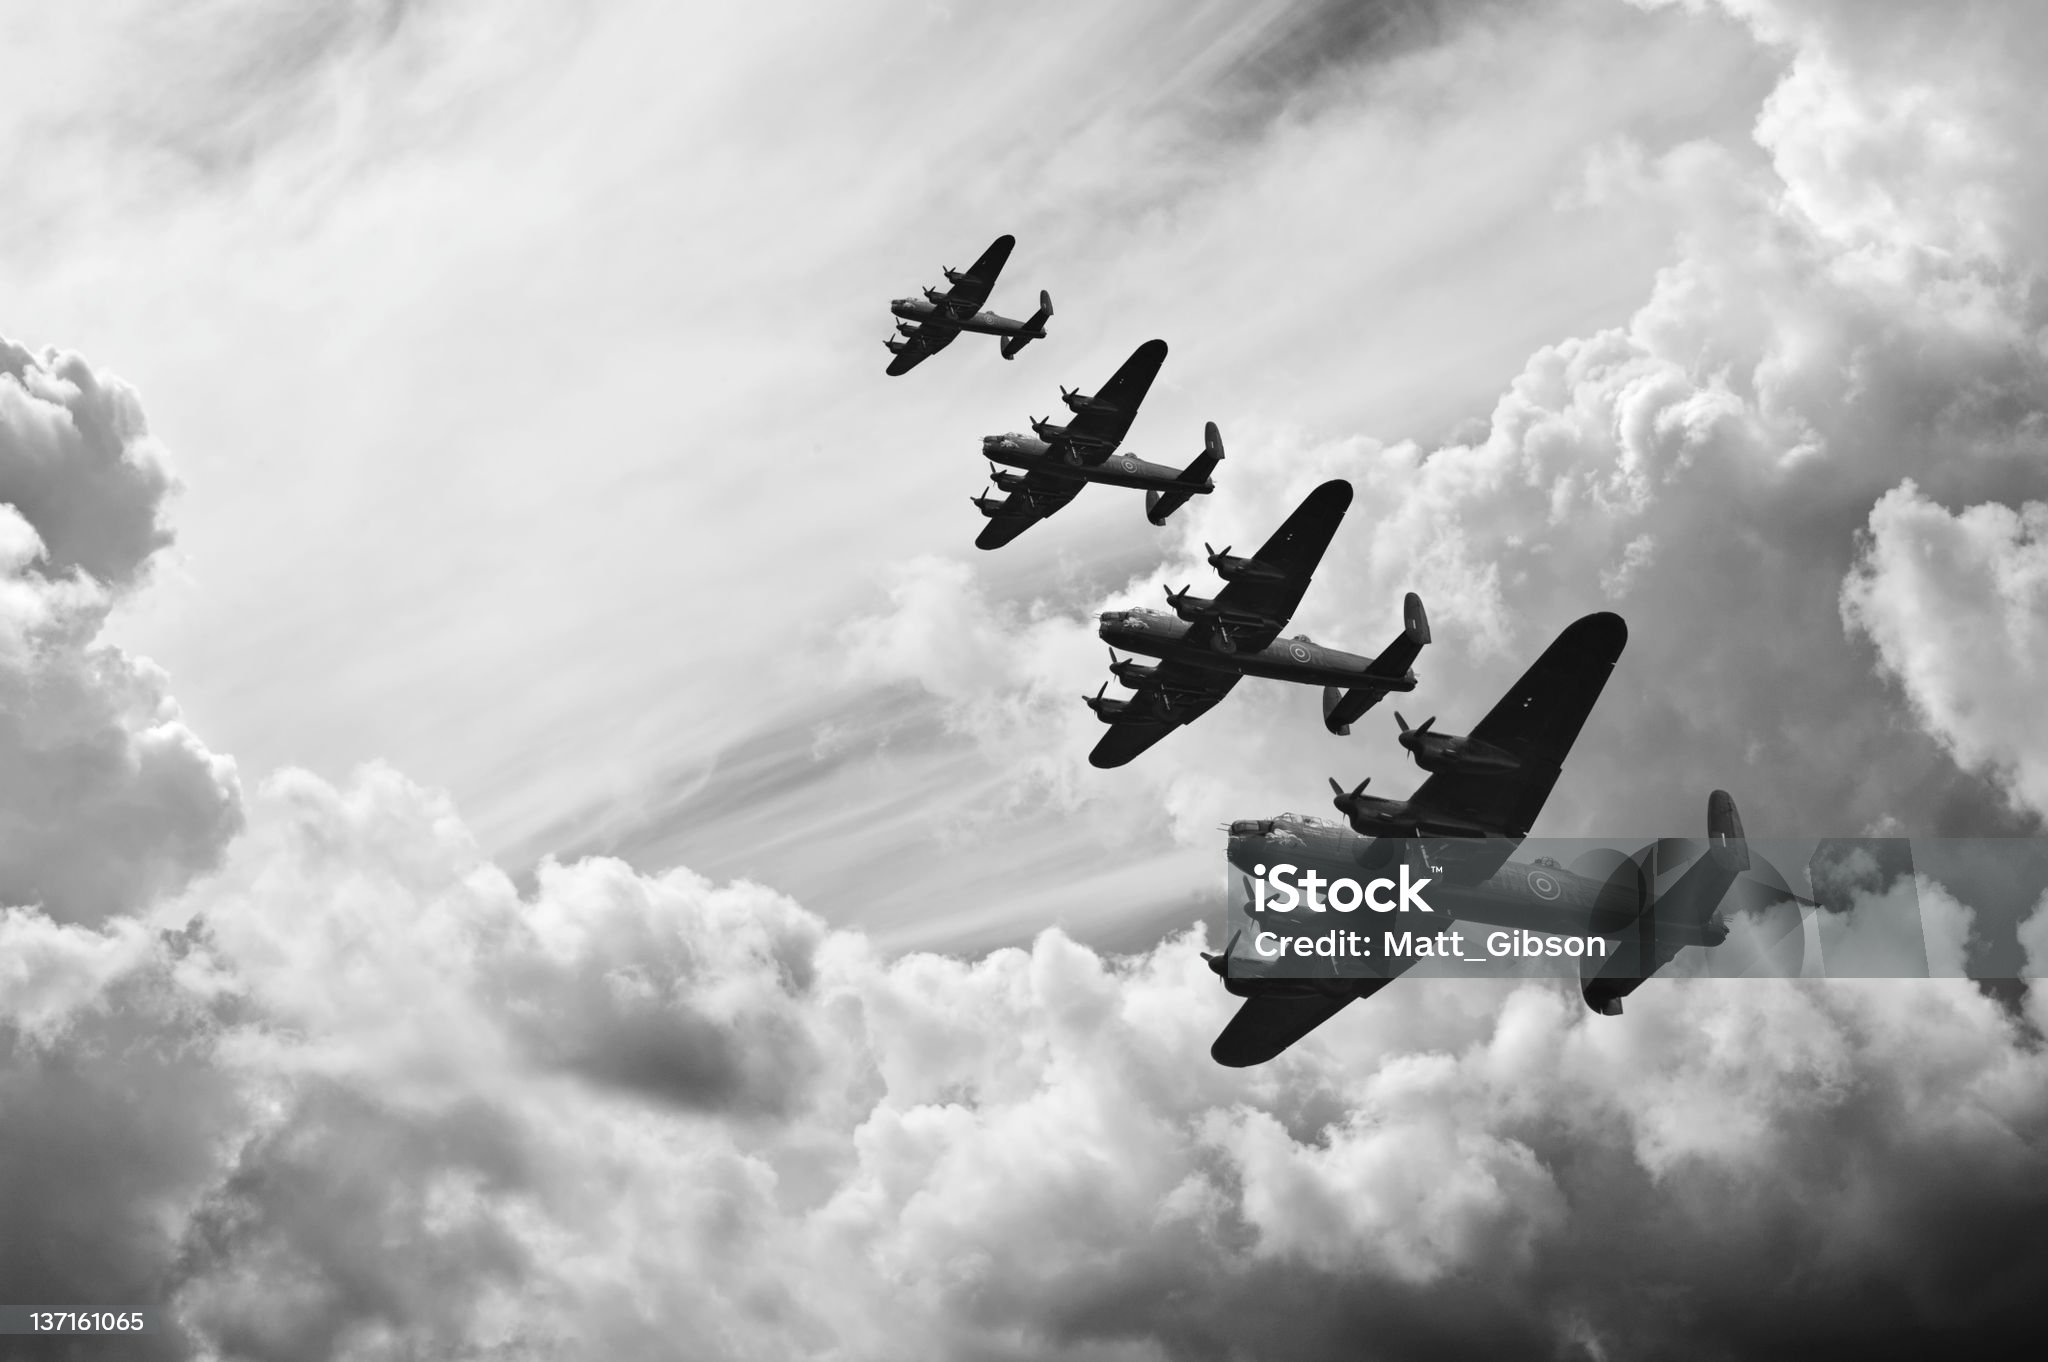

In [23]:
url = 'https://media.istockphoto.com/id/137161065/photo/black-and-white-retro-image-battle-of-britain-ww2-airplanes.jpg?s=2048x2048&w=is&k=20&c=Jz2bU42350cubRWL99VVqefhcBiSMX4E7hPzxJFqV_s='
image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
image

torch.Size([1, 3, 128, 128])


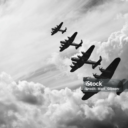

In [24]:
x_start = transform(image).unsqueeze(0)
print(x_start.shape)
reverse_transform(x_start.squeeze())

In [42]:
# Test the adding noise visually
def construct_noisy_image(x_start, t):
    x_noisy = q_sample(x_start, alphas=Alphas(total_timestamps=300), t=t)
    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())
    return noisy_image

def plot_examples(images: List):
    image_num = len(images)
    plt.figure()
    fig, axs = plt.subplots(figsize=(200,200), nrows=1, ncols=image_num)
    for i in range(image_num):
        axs[i].imshow(np.asarray(images[i]))


<Figure size 640x480 with 0 Axes>

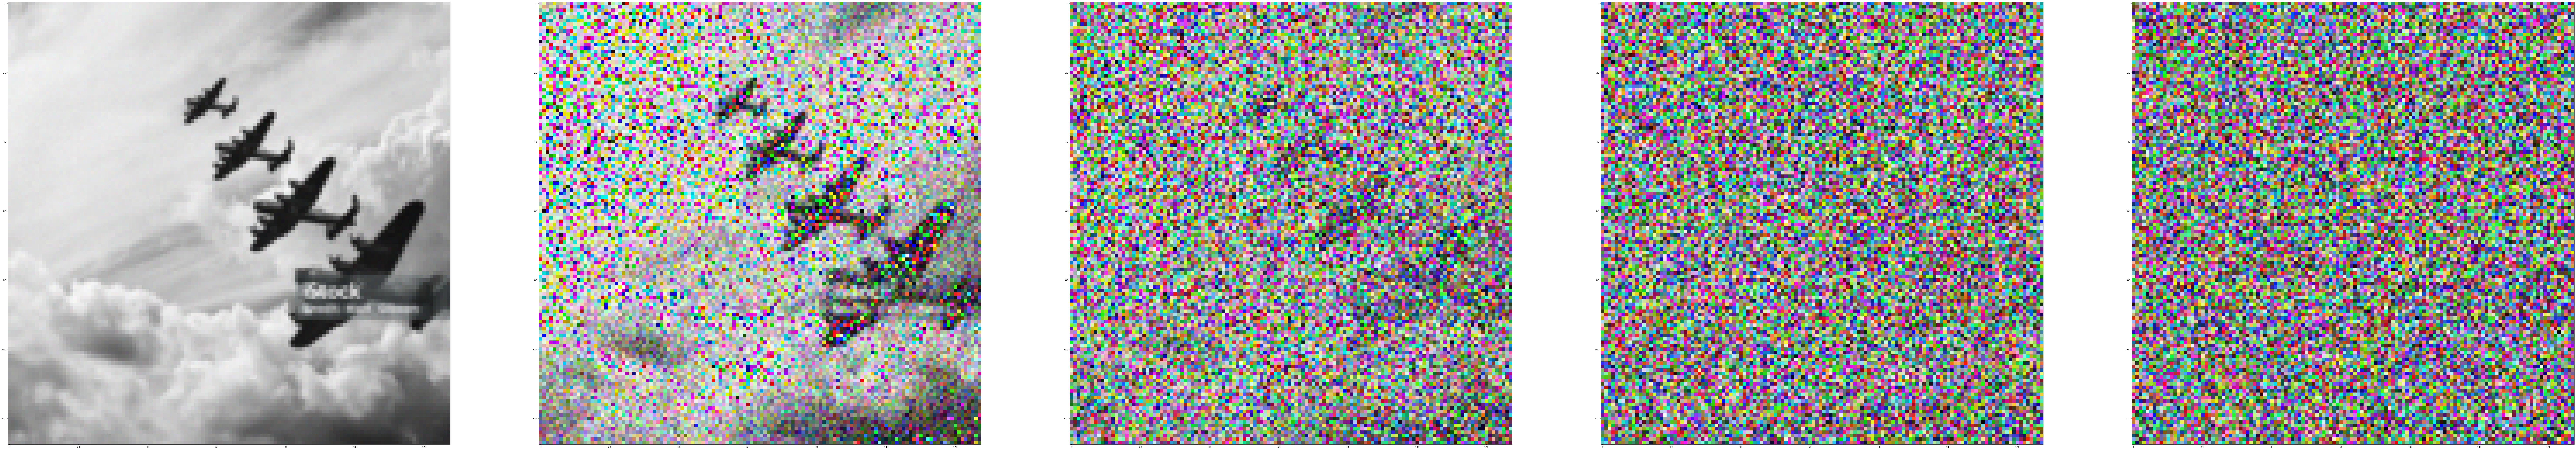

In [43]:
plot_examples([construct_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [81]:
# quick test the Unet module.
device = "cuda" if torch.cuda.is_available() else "cpu"
dim = 64
channels = 3
batch_size = 10
image_w = 64
image_h = 64
model = Unet(
    dim=dim,
    channels=channels,
    dim_mults=(1, 2, 4,)
)


in-out
[(64, 64), (64, 128), (128, 256)]


In [82]:
test_input = torch.rand(batch_size, channels, image_h, image_w)
time = torch.ones(batch_size)
print(test_input.shape)
print(time)

torch.Size([10, 3, 64, 64])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [83]:
output = model.forward(test_input, time)
print(output.shape)

torch.Size([10, 3, 64, 64])


In [89]:
alphas = Alphas(300)
x_start = output
t = torch.ones(batch_size)
q = q_sample(x_start, t, alphas)
print(q.shape)
print(q)

torch.Size([10, 3, 64, 64])
tensor([[[[-0.2169, -0.2835, -0.3697,  ..., -0.2757, -0.2834, -0.1078],
          [-0.3001, -0.3842, -0.3033,  ..., -0.4034, -0.3647, -0.2027],
          [-0.2654, -0.2495, -0.3682,  ..., -0.4222, -0.3968, -0.1908],
          ...,
          [-0.1357, -0.4165, -0.2815,  ..., -0.3759, -0.3149, -0.1403],
          [-0.2286, -0.2312, -0.3532,  ..., -0.2507, -0.3031, -0.1748],
          [-0.1526, -0.2784, -0.3050,  ..., -0.1875, -0.2545, -0.1858]],

         [[ 0.5804,  0.5359,  0.5682,  ...,  0.5878,  0.4180,  0.4088],
          [ 0.5519,  0.5971,  0.5239,  ...,  0.6572,  0.4947,  0.6289],
          [ 0.5059,  0.4649,  0.5404,  ...,  0.5652,  0.5359,  0.5321],
          ...,
          [ 0.4405,  0.4811,  0.4947,  ...,  0.4824,  0.4367,  0.5155],
          [ 0.5460,  0.5186,  0.6550,  ...,  0.5337,  0.4843,  0.4992],
          [ 0.5771,  0.4333,  0.5151,  ...,  0.4519,  0.5120,  0.4911]],

         [[-0.4066, -0.4463, -0.4469,  ..., -0.4427, -0.3865, -0.3697],
  